In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
from warnings import filterwarnings
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

In [ ]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab Notebooks/brain_tumors_dataset/Training/',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Colab Notebooks/brain_tumors_dataset/Testing/' ,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:01<00:00, 71.38it/s]


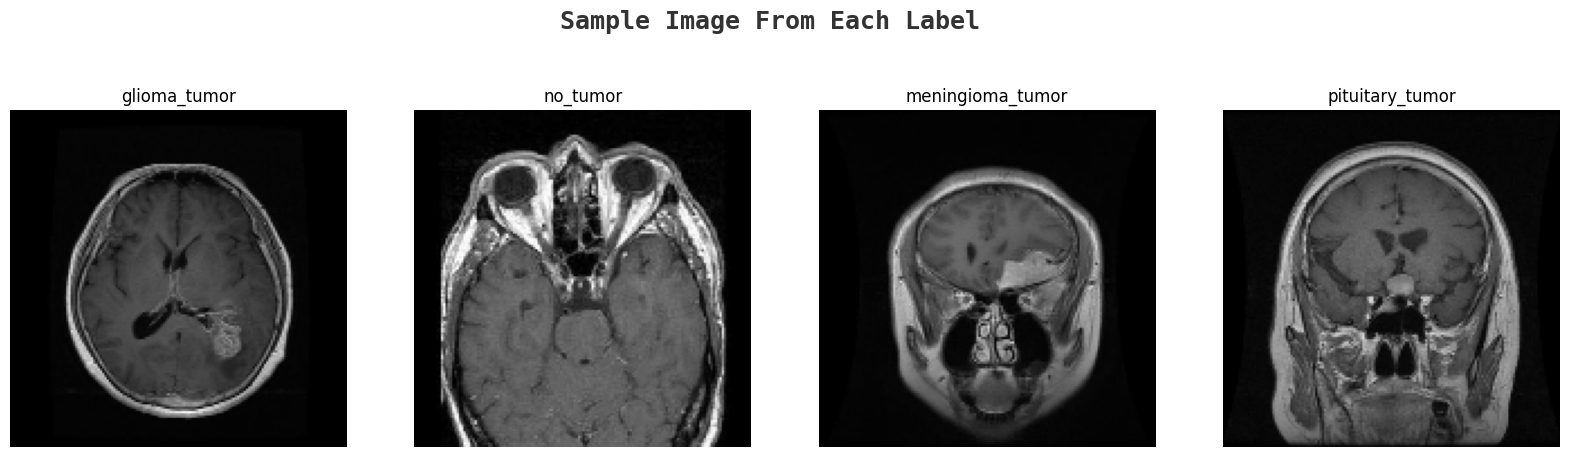

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
X_train.shape, y_train.shape

((2955, 150, 150, 3), (2955,))

In [ ]:
X_test.shape, y_test.shape

((329, 150, 150, 3), (329,))

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)

# Find unique class labels
unique_labels = np.unique(y_test_labels)

print("Unique class labels:", unique_labels)
# 'glioma_tumor':0
# 'no_tumor':1,
# 'meningioma_tumor':2,
# 'pituitary_tumor':3

Unique class labels: [0 1 2 3]


In [ ]:
# Define the input shape
# image_size = 224  # VGG-16 typically uses 224x224 input size

# Load the VGG-16 model without the top (fully connected) layers
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))


In [ ]:
# Add the custom layers on top of VGG-16 base model
model = vgg16_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)

# Create the final model
model = tf.keras.models.Model(inputs=vgg16_model.input, outputs=model)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg16_model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

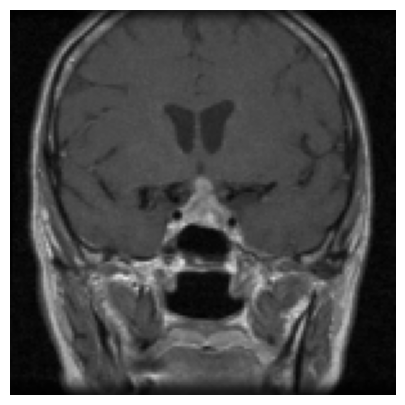

In [ ]:
plot_model(model, show_shapes=True, dpi=300)

# Display the plot
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

In [20]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
84/84 [==============================] - ETA: 0s - loss: 4.0433 - accuracy: 0.2753 
Epoch 1: val_accuracy improved from -inf to 0.28716, saving model to vgg16_model.keras
84/84 [==============================] - 2634s 31s/step - loss: 4.0433 - accuracy: 0.2753 - val_loss: 1.4036 - val_accuracy: 0.2872 - lr: 0.0010
Epoch 2/15
84/84 [==============================] - ETA: 0s - loss: 1.5105 - accuracy: 0.2930 
Epoch 2: val_accuracy did not improve from 0.28716
84/84 [==============================] - 2586s 31s/step - loss: 1.5105 - accuracy: 0.2930 - val_loss: 1.3729 - val_accuracy: 0.2770 - lr: 0.0010
Epoch 3/15
84/84 [==============================] - ETA: 0s - loss: 1.4019 - accuracy: 0.2907 
Epoch 3: val_accuracy did not improve from 0.28716

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
84/84 [==============================] - 2588s 31s/step - loss: 1.4019 - accuracy: 0.2907 - val_loss: 1.3730 - val_accuracy: 0.2534 - lr: 0.0010
Epoch 4/15
84/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-d89c3fd159bd>", line 1, in <cell line: 1>
    history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 832, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/

TypeError: object of type 'NoneType' has no len()

NameError: name 'history' is not defined

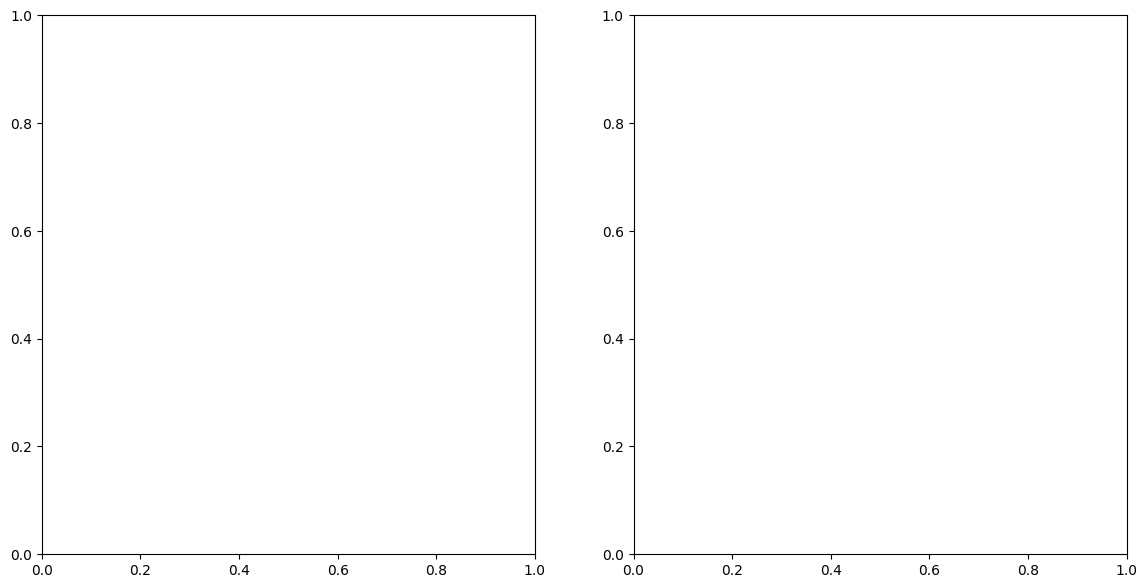

In [22]:
filterwarnings('ignore')

epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [23]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

 2/11 [====>.........................] - ETA: 1:19

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_test_new,pred))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()

def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')

button.on_click(on_button_clicked)
widgets.VBox([button,out])